# Learning Distance


## Neural Network or Multilayer Perceptron
A Multilayer Perceptron consists of an input layer, multiple hiddenlayers and an output layer. The MLP is a feedforward algorithm, because inputs are combined with the initial weights in a weighted sum and subjected to the activation function, just like in the simple Perceptron. But the difference is that each linear combination is propagated to the next layer. Each layer is feeding the next one with the result of their computation. This goes through all the hidden layers to the output layer.

The advantage of a multilayer perceptron compared to a classical perceptron (single layer) is that it is capable of learning a function between input and output that is non linear. Therfore it can learn signifacently more complex functions capturing the relation from input to output data.

This tutorial will give a brief overview into training and testing an MLP and heighlight typical pitfalls that might occure easily.


# Coding: Getting Started
Before you get started you need to follow the descriptions of the Git-Repository and make sure that all required packages are properly installed. It is recommended to work in a virtual environment. Start your virtual environment **before** you launch this jupyter-notebook. Then you may need to change the kernel: *Kernel &rarr; Change kernel &rarr; venv*

In [1]:
import torch
import cv2
import os 
import glob
import argparse
import data_setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mlp_utils as mlp_utils
import train_utils
from tqdm.auto import tqdm
from model import DistNet_MLP as mlp
from matplotlib.pyplot import cm

/Users/piabideau/Documents/scioi/summer-school/tutorial/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
YOLO_MODEL = './model/yolo_model.pt'
FILE = '../../data/test/img/2023-6-28_17-06-35-343099.png'

PATH_TRAIN = '../../data/train/img'
PATH_VAL = '../../data/val/img'
PATH_TEST = '../../data/test/img'
PATH_CSV_TRAIN = '../../data/train/train.csv'
PATH_CSV_VAL = '../../data/val/val.csv'
PATH_CSV_TEST = '../../data/test/test.csv'

PATH_MODEL_SAVE = './model/mlp_model_trained.pth'
ROBOTS = ["ollie", "grace", "alan", "hermann", "kaethe"]
CAM_ROBOT = "ollie"
MAX_DIST = 5
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
FILE_EXTENSION = "*.png"
CONFIDENCE = 0.7
NUM_EPOCHS = 100
RELOAD_WEIGHTS = True
LR = 0.0001

In [3]:
# Loading YOLOv5 Model
model_YOLO = torch.hub.load('ultralytics/yolov5', 'custom', path=YOLO_MODEL, verbose=False)
model_YOLO.conf = CONFIDENCE
model_YOLO.to(DEVICE)

YOLOv5 🚀 2023-8-13 Python-3.11.4 torch-2.0.1 CPU

Fusing layers... 
YOLOv5s summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 


AutoShape(
  (model): DetectMultiBackend(
    (model): DetectionModel(
      (model): Sequential(
        (0): Conv(
          (conv): Conv2d(3, 32, kernel_size=(6, 6), stride=(2, 2), padding=(2, 2))
          (act): SiLU(inplace=True)
        )
        (1): Conv(
          (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (act): SiLU(inplace=True)
        )
        (2): C3(
          (cv1): Conv(
            (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
            (act): SiLU(inplace=True)
          )
          (cv2): Conv(
            (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
            (act): SiLU(inplace=True)
          )
          (cv3): Conv(
            (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
            (act): SiLU(inplace=True)
          )
          (m): Sequential(
            (0): Bottleneck(
              (cv1): Conv(
                (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
  

## Part 1.1: Training a small MLP (multi-layer perceptron)

The provided code automatically detects little Lego Robots in an image. For detection we use a fine-tuned YOLOv5 network that estimates bounding boxes, that each capture the rough dimensions of the projected object.
Given the height of an object bounding box, the camera's focal length as well as the actual robot's height we compute the absolut distance between "CAM_ROBOT" and all visible robots in the image.

In [4]:
# Load the training and validation image sets.
file_pattern = os.path.join(PATH_TRAIN, FILE_EXTENSION)
train_images = glob.glob(file_pattern)

file_pattern = os.path.join(PATH_VAL, FILE_EXTENSION)
valid_images = glob.glob(file_pattern)

# Pass images through yolo and get bounding boxes with their corresponding csv distance labels
train_data = mlp_utils.images2data(model_YOLO, train_images, PATH_CSV_TRAIN, verbose = False)
valid_data = mlp_utils.images2data(model_YOLO, valid_images, PATH_CSV_VAL, verbose = False)

In [5]:
# Load the MLP model
model_MLP = mlp.MLP()

# Define optimizer
optimizer = torch.optim.Adam(params=model_MLP.parameters(), lr=LR)
loss_fn = torch.nn.MSELoss()

# Pass the data through the dataloader
train_dataloader, valid_dataloader = data_setup.create_dataloader(train_data, valid_data, batch_size=5)
train_features_batch, train_labels_batch = next(iter(train_dataloader))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.69it/s]


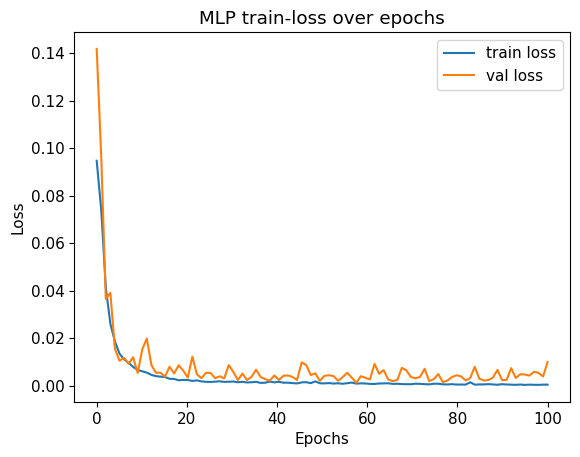

In [6]:
# Set training
best_metric = float('inf')  # Initialize with a large value for loss
train_loss_plotting = []
validation_loss_plotting = []

# Training Loop
for epoch in tqdm(range(NUM_EPOCHS)):
    train_loss = train_utils.train_step(model_MLP, train_dataloader, loss_fn, optimizer, DEVICE)
    validation_loss = train_utils.validation_step(model_MLP, valid_dataloader, loss_fn, DEVICE)
    
    #print(train_loss)

    # add train loss fro plotting
    train_loss_plotting.append(train_loss.item())
    validation_loss_plotting.append(validation_loss.item())
  
    if validation_loss < best_metric:
        best_metric = validation_loss
        torch.save(model_MLP.state_dict(), PATH_MODEL_SAVE)

#    if(epoch % 10 == 0):
#        print(f"Epoch: {epoch}\n------")
#        print(f"Train loss: {train_loss:.5f}\n")
        
# plotting stuff
%matplotlib inline
x_err = np.linspace(0, NUM_EPOCHS, NUM_EPOCHS)
plt.plot(x_err, train_loss_plotting, label='train loss')
plt.plot(x_err, validation_loss_plotting, label='val loss')

# Adding labels and title
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('MLP train-loss over epochs')

# Display the plot
plt.legend()

plt.show()

### Question: 
Can you overfit intentionally to the training data? How does the validation curve will look like? Please verify your assumption.

How does the number of layers effect the training result of the MLP?

*Answer:*

## Part 1.2: Inference on a single image

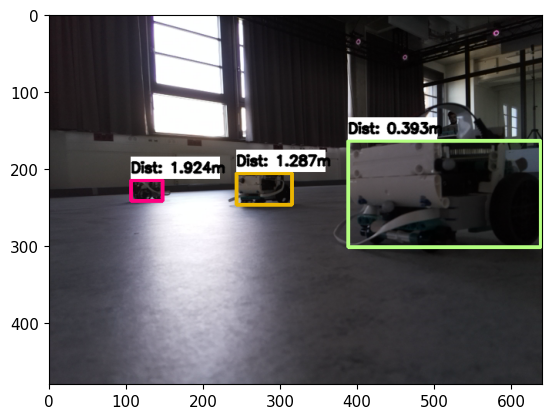

In [8]:
# loading trained model
model = mlp.MLP()
model.load_state_dict(torch.load(PATH_MODEL_SAVE, map_location=torch.device(DEVICE)))
model.eval() 

# yolo bounding box detection
res = model_YOLO(FILE)

bounding_boxes = res.xyxy[0][res.xyxy[0][:, 0].sort()[1]]
image = cv2.imread(FILE)
color = iter(cm.rainbow(np.linspace(0, 1, 5)))

for box in bounding_boxes:
    
    BBH = (box[3] - box[1]) / 640

    input = torch.stack((torch.tensor(1).to(DEVICE), BBH))
    distance = model(input)
    
    c = next(color)
    cv2.rectangle(image, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])), c[0:3]*255, 3)
    image_with_rectangle = cv2.rectangle(image, (int(box[0]), int(box[1])-30), (int(box[0]) + 115, int(box[1]-2)), (255,255,255), -1)
    img_drawn = cv2.putText(image, f"Dist: {(distance.item() * MAX_DIST):.3f}m", (int(box[0]), int(box[1] - 10)), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,0,0), 2, cv2.LINE_AA)
    image_rgb = cv2.cvtColor(img_drawn, cv2.COLOR_BGR2RGB)


# visualize frame with overlayed 
# bounding boxes and distance estimates
%matplotlib inline

fig = plt.figure()
plt.imshow(image_rgb)
plt.show()

## Part 1.3: Visualization

... now let's run this code on several consequtive frames and visualize the relationship between object height and its distance.

In [11]:
print("Loading Pictures...")

file_pattern = os.path.join(PATH_TEST, FILE_EXTENSION)
picture_files = glob.glob(file_pattern)
picture_files.sort()

print("Reading pictures...")

values = {}

first_image = cv2.imread(picture_files[0])
height, width, _ = first_image.shape

for i, file in enumerate(picture_files):

    res = model_YOLO(file)
    bounding_boxes = res.xyxy[0][res.xyxy[0][:, 0].sort()[1]]

    for box in bounding_boxes:
        BBH = (box[3] - box[1]) / 640

        input = torch.stack((torch.tensor(1).to(DEVICE), BBH))
        distance = model(input)
        
        values.setdefault(distance, []).append(box[3] - box[1])



Loading Pictures...
Reading pictures...


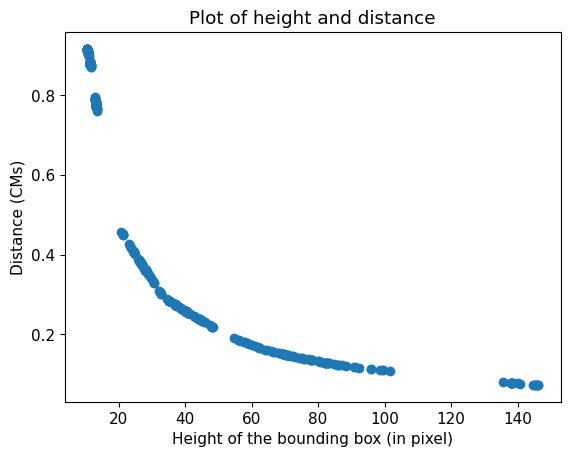

In [12]:
x = []
y = []

for dist in values:
    for height in values[dist]:
        x.append(height.item())
        y.append(dist.detach().numpy())

plt.scatter(x, y)

plt.xlabel('Height of the bounding box (in pixel)')
plt.ylabel('Distance (CMs)')
plt.title('Plot of height and distance')

plt.show()

## Part 2.1: Evaluation

Groudtruth robot poses were captured with a motion capture system for all robots visible in this data. Poses were saved in the provided .csv file. In this part of the tutorial let's anayse the observed error. How does this relate to the object's distance? What are possible causes of this error?

In [14]:
# loading trained model
model = mlp.MLP()
model.load_state_dict(torch.load(PATH_MODEL_SAVE, map_location=torch.device(DEVICE)))
model.eval()

# get list of picture files in PATH
file_pattern = os.path.join(PATH_TRAIN, FILE_EXTENSION)
picture_files = glob.glob(file_pattern)
picture_files.sort()

# read csv file with ground truth robot poses
df = pd.read_csv(PATH_CSV_TRAIN, header=None)

# get column for each robot in csv file
row = df.iloc[0].to_numpy()
robot_col = {}
for rbo in ROBOTS:
    bool_array = row == rbo
    robot_col[rbo] = bool_array.argmax()
cam_robot_col = robot_col[CAM_ROBOT]

err = []
distance_x = []

for i, file in enumerate(picture_files):

    # -----------------------------------------------------------------
    # LOAD GROUNDTRUTH DISTANCES FOR EACH PICTURE
    # -----------------------------------------------------------------
    
    row_val = os.path.basename(file)
    row_matching_value = df[df.iloc[:, 0] == row_val]
    print("********")
    print(row_val)

    if row_matching_value.empty:
        print("Skipping, since no matching image name in csv")
        continue

    row = row_matching_value.index[0]

    if type(df.at[row,2]) is not str and math.isnan(df.at[row,2]):
        print("Skipping, since no robots visable on image ")
        continue
       
    # robots present in current frame
    robot_list = df.at[row,2].split()
    
    distance_gt = []
    
    for robot in zip(robot_list):
        
        # pose of the camera robot
        camX = df.at[row,cam_robot_col+2]
        camY = df.at[row,cam_robot_col]

        # pose of neighboring robot
        robotX = df.at[row, robot_col[robot[0]] + 2]
        robotY = df.at[row, robot_col[robot[0]]]

        # GROUNDTRUTH DISTANCE
        distance = np.sqrt((float(robotX)-float(camX)) ** 2 + (float(robotY)-float(camY)) ** 2)
        distance = distance / 100
        
        print(f"distance_gt: {distance}")
        
        distance = torch.tensor(distance, dtype = torch.float32,)
        distance_gt.append(distance)
        
    # -----------------------------------------------------------------
    # COMPUTE DISTANCE FROM BOUNDING BOX HEIGHT
    # -----------------------------------------------------------------
    
    res = model_YOLO(file)
    bounding_boxes = res.xyxy[0][res.xyxy[0][:, 0].sort()[1]]

    distance_estim = []
    
    for box in bounding_boxes:
    
        BBH = (box[3] - box[1]) / 640

        input = torch.stack((torch.tensor(1).to(DEVICE), BBH))
        distance = model(input)
        distance = distance[0].detach()
        distance_estim.append(distance * MAX_DIST)
        
        print(f"distance_estim: {distance * MAX_DIST}")
        
    # -----------------------------------------------------------------
    # COMPUTE ERROR
    # -----------------------------------------------------------------
    
    if(bounding_boxes.shape[0] == len(robot_list)):

        error = abs(np.array(distance_gt) - np.array(distance_estim))
        err.extend(error)
        distance_x.extend(distance_gt)

********
2023-6-28_17-14-45-756992.png
distance_gt: 0.3155240818351403
distance_gt: 3.778328848866088
distance_gt: 4.927410998490273
distance_gt: 3.678965914334902
distance_estim: 0.31572964787483215
distance_estim: 4.274003028869629
distance_estim: 4.803496837615967
distance_estim: 3.897751808166504
********
2023-6-28_17-14-45-798767.png
distance_gt: 0.31194829970741805
distance_gt: 3.7783595390285143
distance_gt: 4.927295745423304
distance_gt: 3.6790048635242454
distance_estim: 0.31527966260910034
distance_estim: 4.283730506896973
distance_estim: 4.800892353057861
distance_estim: 3.9152989387512207
********
2023-6-28_17-14-45-840106.png
distance_gt: 0.30869088965782093
distance_gt: 3.778347856993213
distance_gt: 4.927295763400836
distance_gt: 3.6789836432355405
distance_estim: 0.3005314767360687
distance_estim: 4.279266357421875
distance_estim: 4.79735803604126
distance_estim: 3.9112377166748047
********
2023-6-28_17-14-45-885886.png
distance_gt: 0.3055268779027879
distance_gt: 3.778

distance_estim: 0.32082152366638184
distance_estim: 4.22929573059082
distance_estim: 4.806905746459961
distance_estim: 3.9132742881774902
********
2023-6-28_17-14-47-168362.png
distance_gt: 0.32324607871646654
distance_gt: 3.778339445175189
distance_gt: 4.927392924619998
distance_gt: 3.678974170378526
distance_estim: 0.32051897048950195
distance_estim: 4.242298126220703
distance_estim: 4.789770126342773
distance_estim: 3.9753053188323975
********
2023-6-28_17-14-47-211557.png
distance_gt: 0.32322930159145424
distance_gt: 3.7783174662471963
distance_gt: 4.927398296299151
distance_gt: 3.678968509677135
distance_estim: 0.31945258378982544
distance_estim: 4.2508769035339355
distance_estim: 4.794323921203613
distance_estim: 3.91953444480896
********
2023-6-28_17-14-47-256633.png
distance_gt: 0.32323189169245553
distance_gt: 3.778329409814662
distance_gt: 4.927403364080032
distance_gt: 3.678968396950067
distance_estim: 0.32067328691482544
distance_estim: 4.223785877227783
distance_estim: 4.7

distance_estim: 0.31813356280326843
distance_estim: 4.19585657119751
distance_estim: 4.78532600402832
distance_estim: 3.9194540977478027
********
2023-6-28_17-14-55-287357.png
distance_gt: 3.778331211389158
distance_gt: 4.9274034403559
distance_gt: 1.4294084358004755
distance_gt: 3.678966544231204
distance_estim: 4.159918308258057
distance_estim: 4.7571306228637695
distance_estim: 1.4111841917037964
distance_estim: 3.3598151206970215
********
2023-6-28_17-14-55-331884.png
distance_gt: 3.778344041429993
distance_gt: 4.927289778332733
distance_gt: 1.4382467195307465
distance_gt: 3.6789625403308475
distance_estim: 4.170432090759277
distance_estim: 4.703162670135498
distance_estim: 1.4387850761413574
distance_estim: 3.5110018253326416
********
2023-6-28_17-14-58-657130.png
distance_gt: 2.2577564584920795
distance_gt: 3.778369762882195
distance_gt: 4.9273263693198786
distance_gt: 3.6789705983103578
distance_estim: 2.4208288192749023
distance_estim: 4.0986008644104
distance_estim: 4.78788948

distance_estim: 2.398777484893799
distance_estim: 4.227079391479492
distance_estim: 4.790891647338867
distance_estim: 3.982698440551758
********
2023-6-28_17-15-00-337031.png
distance_gt: 2.3834441122096526
distance_gt: 3.778332752881441
distance_gt: 4.927307940657737
distance_gt: 3.678967780570705
distance_estim: 2.4018023014068604
distance_estim: 4.215921401977539
distance_estim: 4.774150371551514
distance_estim: 3.9917514324188232
********
2023-6-28_17-15-00-379551.png
distance_gt: 2.3835739325417142
distance_gt: 3.7783481546154847
distance_gt: 4.92739919925949
distance_gt: 3.678976871948153
distance_estim: 2.394737720489502
distance_estim: 4.219041347503662
distance_estim: 4.789664268493652
distance_estim: 3.9670090675354004
********
2023-6-28_17-15-00-464567.png
distance_gt: 2.383904999832443
distance_gt: 3.778376592321213
distance_gt: 4.927421289570963
distance_gt: 3.678985426536242
distance_estim: 2.396868944168091
distance_estim: 4.226605415344238
distance_estim: 4.786119937896

distance_estim: 2.442711353302002
distance_estim: 4.064128875732422
distance_estim: 4.778045654296875
distance_estim: 3.958010196685791
********
2023-6-28_17-15-03-266585.png
distance_gt: 3.7783729340548757
distance_gt: 2.175760535613336
distance_gt: 4.927361176783253
distance_gt: 3.6789690836229614
distance_estim: 4.346742153167725
distance_estim: 2.3089699745178223
distance_estim: 4.7276740074157715
distance_estim: 3.960930109024048
********
2023-6-28_17-15-03-308114.png
distance_gt: 3.778325821805899
distance_gt: 2.1707483107922068
distance_gt: 4.927401295601487
distance_gt: 3.678956230728284
distance_estim: 4.333261489868164
distance_estim: 2.3123624324798584
distance_estim: 4.72603178024292
distance_estim: 4.007516860961914
********
2023-6-28_17-15-03-349913.png
distance_gt: 3.7783744381623108
distance_gt: 2.1649026284115176
distance_gt: 4.927405458809481
distance_gt: 3.6789606760957567
distance_estim: 4.27056360244751
distance_estim: 2.3138256072998047
distance_estim: 4.742759227

distance_estim: 0.7503653764724731
distance_estim: 1.9210484027862549
********
2023-6-28_17-15-29-607859.png
distance_gt: 0.686806537463767
distance_gt: 1.8768950288940922
distance_estim: 0.6841802597045898
distance_estim: 1.836547613143921
********
2023-6-28_17-15-29-653416.png
distance_gt: 0.6709758308589092
distance_gt: 1.8619548775614467
distance_estim: 0.6678391098976135
distance_estim: 1.8140417337417603
********
2023-6-28_17-15-29-697496.png
distance_gt: 0.6566806838915042
distance_gt: 1.8487894485026795
distance_estim: 0.6430068016052246
distance_estim: 1.7728583812713623
********
2023-6-28_17-15-29-740273.png
distance_gt: 0.6442086240270821
distance_gt: 1.8372619984344656
distance_estim: 0.6221375465393066
distance_estim: 1.7748820781707764
********
2023-6-28_17-15-29-784166.png
distance_gt: 0.6303864849687957
distance_gt: 1.8245520185284574
distance_estim: 0.6032837629318237
distance_estim: 1.7234827280044556
********
2023-6-28_17-15-29-827286.png
distance_gt: 0.6181173990194

distance_estim: 1.0646159648895264
********
2023-6-28_17-15-34-194325.png
distance_gt: 0.9675819637710128
distance_estim: 1.0520802736282349
********
2023-6-28_17-15-34-237856.png
distance_gt: 0.9538230645415554
distance_estim: 1.035573959350586
********
2023-6-28_17-15-34-281934.png
distance_gt: 0.939700863135403
distance_estim: 1.0261784791946411
********
2023-6-28_17-15-34-325878.png
distance_gt: 0.9255060740741736
distance_estim: 1.0089995861053467
********
2023-6-28_17-15-34-369755.png
distance_gt: 0.9110315310369814
distance_estim: 0.9987106323242188
********
2023-6-28_17-15-34-413690.png
distance_gt: 0.8976796692732414
distance_estim: 0.9855291843414307
********
2023-6-28_17-15-34-457619.png
distance_gt: 0.8831900727656375
distance_estim: 0.970385730266571
********
2023-6-28_17-15-34-501400.png
distance_gt: 0.8689557489516289
distance_estim: 0.9579699635505676
********
2023-6-28_17-15-34-586874.png
distance_gt: 0.8409860124119021
distance_estim: 0.9211312532424927
********
2023-

NameError: name 'math' is not defined

## Part 2.2: Visualization
...now let's visualize again.

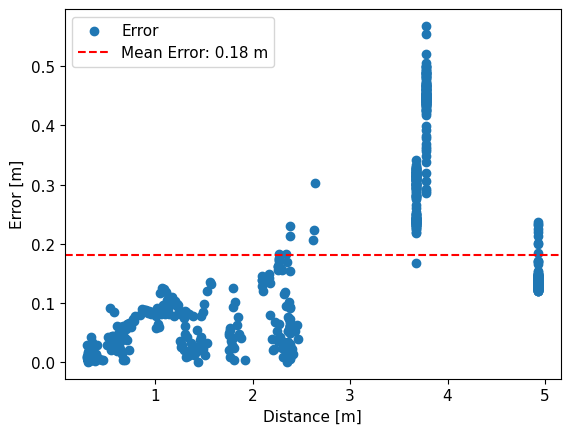

In [15]:
plt.scatter(distance_x, err, label='Error')
mean_err = np.mean(err)
plt.axhline(y=mean_err, color='r', linestyle='--', label=f'Mean Error: {mean_err:.2f} m')

# Adding labels and title
plt.xlabel('Distance [m]')
plt.ylabel('Error [m]')

# Display the plot
plt.legend()
plt.show(block=True)

## Question 1:
Please describe the behavior of the error. What are possible causes for errors that you observe? (Please name at least three causes)

*Answer:*